## Text Analytics - MsC Data Science (part time) 24' | 3rd Assignement

| Name      | CV |
|-----------|-----|
| Τριάντης Γεώργιος      | p3352303  |
| Μπαλτάς Ιωάννης     | p3352307 |
| Πλυμένος Παπαγέωργας Ιάσων   | p3352327  |
| Νίτσος Θεοφάνης   | p3352325  |


# Exercise 9

In [ ]:
!pip install -U nltk
!pip install datasets
!pip install --upgrade tensorflow
!pip install spacy
!pip install tqdm
!pip install -U gensim
!pip install torch torchvision
!pip install -U keras-tuner

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Import and split the dataset into training and test subsets

* The dataset has 20000 words
* 70% Training - 15% Test - 15%

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Extract text and labels for train and test sets
X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_val = dataset["validation"]["text"]
y_val = dataset["validation"]["label"]
X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]


# Confirm the sizes of train and validation sets
print("Train set size: {}".format(len(X_train)))
print("Validation set size: {}".format(len(X_val)))
print("Validation set size: {}".format(len(X_test)))


/home/gtriant/.local/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Train set size: 16000
Validation set size: 2000
Validation set size: 2000


In [ ]:
# Map integer labels to their corresponding string names
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
    # Add more mappings as needed
}

# Extract distinct labels from the training set
distinct_train_labels = set(y_train)

# Print distinct train label names with their string representations
print("Distinct train label names:")
for label in distinct_train_labels:
    label_name = label_mapping.get(label, "Unknown")
    print(f"Label {label}: {label_name}")


Distinct train label names:
Label 0: sadness
Label 1: joy
Label 2: love
Label 3: anger
Label 4: fear
Label 5: surprise


### Tokenize the dataset

* Split into sentences
* Tokenize into words

In [ ]:
import spacy.cli
import spacy
spacy.cli.download("en_core_web_sm")
from tqdm import tqdm

# Load English language model in spaCy and disable unnecessary components
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')  # Add a pipeline component for sentence segmentation

def tokenize_samples(samples):
    tokenized_samples = []
    for i in tqdm(range(len(samples))):
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:
            for tok in sent:  # Iterate through the words of the sentence
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text:
                    continue
                if tok.text.strip():
                    tokens.append(tok.text.replace('"', "'").strip())
        tokenized_samples.append(tokens)
    return tokenized_samples

# Tokenize the training, validation and test samples
X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


  0%|                                                 | 0/16000 [00:00<?, ?it/s]/home/gtriant/.local/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 545.32it/s]


In [ ]:
for item in X_train_tokenized[:5]:
  print(item)
  print()

['i', 'did', 'nt', 'feel', 'humiliated']

['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake']

['i', 'm', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']

['i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still', 'on', 'the', 'property']

['i', 'am', 'feeling', 'grouchy']



## TF-IDF

* MLP classifiers expect **numerical input data**, so we'll need to convert our tokenized samples into a numerical format before feeding them into the MLP
* Convert list of tokens to strings (sentences) because that is the format that TfidVectorizer() expects
* Initialize a TfidfVectorizer(),
* Fit it on the training data to learn the vocabulary and IDF weights, and
* transform both the training and validation data into TF-IDF feature matrices.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized lists to strings
X_train_str = [' '.join(tokens) for tokens in X_train_tokenized]
X_val_str = [' '.join(tokens) for tokens in X_val_tokenized]
X_test_str = [' '.join(tokens) for tokens in X_test_tokenized]

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)

# Transform validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val_str)

# Transform validation data
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

In [ ]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

## k-nn Classifier as baseline

* We use MinMaxScaler to scale the centroid representations to the range [0, 1].
* We train the KNN classifier (KNeighborsClassifier) using the scaled centroid representations (X_train_scaled) and their corresponding labels (y_train).
* We evaluate the classifier's performance on both the training and validation sets using F1 score with average='micro'
* We print the classification report for the validation set and display the confusion matrix.

Training took: 0.0062885284423828125 seconds 

Train f1-score: 78.73%
Validation f1-score: 63.40% 

Classification Report for validation data:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       550
           1       0.66      0.71      0.69       704
           2       0.66      0.41      0.51       178
           3       0.52      0.53      0.53       275
           4       0.57      0.56      0.56       212
           5       0.80      0.44      0.57        81

    accuracy                           0.63      2000
   macro avg       0.65      0.56      0.59      2000
weighted avg       0.64      0.63      0.63      2000


Confusion Matrix for validation data:


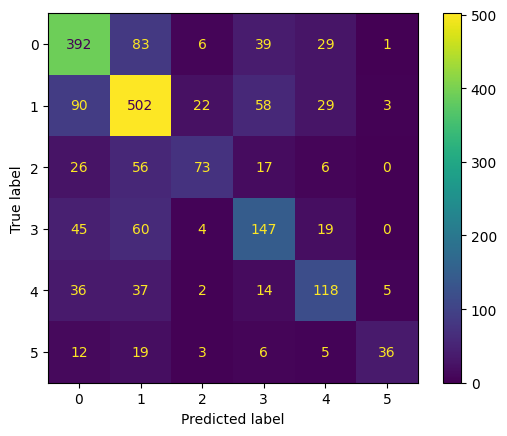

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import time

# Scale centroid representations to non-negative range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_svd)
X_val_scaled = scaler.transform(X_val_svd)

# Train KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
clf.fit(X_train_scaled, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate on train set
train_predictions = clf.predict(X_train_scaled)
train_f1_score = f1_score(y_train, train_predictions, average='micro')
print("Train f1-score: {:.2f}%".format(train_f1_score * 100))

# Evaluate on validation set
val_predictions = clf.predict(X_val_scaled)
val_f1_score = f1_score(y_val, val_predictions, average='micro')
print("Validation f1-score: {:.2f}% \n".format(val_f1_score * 100))

# Print classification report for validation set
print("Classification Report for validation data:")
print(classification_report(y_val, val_predictions))

# Confusion matrix for validation set
print("\nConfusion Matrix for validation data:")
conf_matrix = confusion_matrix(y_val, val_predictions)
ConfusionMatrixDisplay(conf_matrix).plot(values_format=".0f")

## **MLP text classifier in Keras with TF-IDF Features**

In [ ]:
import tensorflow as tf

# Convert with Keras
y_train_1_hot = tf.keras.utils.to_categorical(y_train,
                                              num_classes=len(distinct_train_labels ))
y_val_1_hot = tf.keras.utils.to_categorical(y_val,
                                            num_classes=len(distinct_train_labels ))
for lidx,label in enumerate(distinct_train_labels ):
  print("Index: {} Category: {}".format(lidx,label))
print("Label index: {} | 1-hot vector:  {}".format(y_train[0],
                                                   y_train_1_hot[0]))
print("Label index: {} | 1-hot vector:  {}".format(y_train[10],
                                                   y_train_1_hot[10]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[20],
                                                   y_train_1_hot[20]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[400],
                                                   y_train_1_hot[400]))


2024-05-16 22:52:32.203878: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 22:52:32.237581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 22:52:32.771293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Index: 0 Category: 0
Index: 1 Category: 1
Index: 2 Category: 2
Index: 3 Category: 3
Index: 4 Category: 4
Index: 5 Category: 5
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 3 | 1-hot vector:  [0. 0. 0. 1. 0. 0.]
Label index: 1 | 1-hot vector:  [0. 1. 0. 0. 0. 0.]


#### Custom functions

* **Metrics Callback Class:** Define a custom callback to calculate and log metrics after each epoch.
    * **__init__ Method:** Initialize with validation data.
    * **on_epoch_end Method:** Execute at the end of each epoch to calculate metrics.
* **Getting Model Predictions:** Predict validation data and convert probabilities to class labels.
* **Convert Targets to Appropriate Format:** Ensure true labels are in the correct format for metric calculations.
* **Calculate Metrics:**
    * **Precision, Recall, F1 Score:** Compute these metrics with zero division handling.
    * **AUC:** Compute the AUC score for multi-class classification.
* **Log and Print Metrics:** Store metrics in the logs dictionary and print them for monitoring.

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import numpy as np

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, train_data, valid_data):
        super(Metrics, self).__init__()
        self.train_data = train_data
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Validation metrics
        val_predict_probs = self.model.predict(self.validation_data[0])
        val_predict = np.argmax(val_predict_probs, -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted", zero_division=0)
        _val_recall = recall_score(val_targ, val_predict, average="weighted", zero_division=0)
        _val_precision = precision_score(val_targ, val_predict, average="weighted", zero_division=0)

        if len(val_targ.shape) == 1:
            val_targ = tf.one_hot(val_targ, depth=val_predict_probs.shape[1])
        _val_auc = roc_auc_score(val_targ, val_predict_probs, average="weighted", multi_class='ovr')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        logs['val_auc'] = _val_auc

        # Training metrics
        train_predict_probs = self.model.predict(self.train_data[0])
        train_predict = np.argmax(train_predict_probs, -1)
        train_targ = self.train_data[1]
        train_targ = tf.cast(train_targ, dtype=tf.float32)
        if len(train_targ.shape) == 2 and train_targ.shape[1] != 1:
            train_targ = np.argmax(train_targ, -1)

        _train_f1 = f1_score(train_targ, train_predict, average="weighted", zero_division=0)
        _train_recall = recall_score(train_targ, train_predict, average="weighted", zero_division=0)
        _train_precision = precision_score(train_targ, train_predict, average="weighted", zero_division=0)

        if len(train_targ.shape) == 1:
            train_targ = tf.one_hot(train_targ, depth=train_predict_probs.shape[1])
        _train_auc = roc_auc_score(train_targ, train_predict_probs, average="weighted", multi_class='ovr')

        logs['train_f1'] = _train_f1
        logs['train_recall'] = _train_recall
        logs['train_precision'] = _train_precision
        logs['train_auc'] = _train_auc

        print(f" — train_f1: {_train_f1:.6f} — train_precision: {_train_precision:.6f} — train_recall: {_train_recall:.6f} — train_auc: {_train_auc:.6f}")
        print(f" — val_f1: {_val_f1:.6f} — val_precision: {_val_precision:.6f} — val_recall: {_val_recall:.6f} — val_auc: {_val_auc:.6f}")
        return



#### Basic MLP MODEL

* **Sequential Model:** A linear stack of layers.
* **First Dense Layer:** 512 neurons, ReLU activation, input dimension is the number of features in X_train_svd.
* **Dropout Layer:** 30% dropout rate to prevent overfitting.
* **Second Dense Layer:** 256 neurons, ReLU activation.
* **Dropout Layer:** 50% dropout rate to prevent overfitting.
* **Output Dense Layer:** Number of neurons equal to the number of distinct labels, softmax activation for multi-class classification.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

# Define and compile the model
model = Sequential()
model.add(Dense(512, input_dim=X_train_svd.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(distinct_train_labels), activation='softmax'))

print(model.summary())


/home/gtriant/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       256,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,382 (1.49 MB)

 Trainable params: 389,382 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

None


* **Compile Model:**
    * **Loss Function:** Categorical cross-entropy for multi-class classification.
    * **Optimizer:** Adam optimizer with a learning rate of 0.001.
    * **Metrics:** Categorical accuracy to measure the performance of the model.
* **Create Directory:** Check if the checkpoints directory exists; if not, create it. This is where the model checkpoints will be saved.
* **ModelCheckpoint Callback:**
    * **Monitor:** Monitors the 'val_f1' score.
    * **Mode:** 'max', meaning it will save the model with the highest 'val_f1' score.
    * **Verbose:** Set to 2 to provide detailed logging.
    * **Save only the best model and the best weights** (with the highest 'val_f1' score).

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=[CategoricalAccuracy()])

# Ensure checkpoints directory exists
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

# Define the checkpoint callback
checkpoint = ModelCheckpoint('checkpoints/tfidf_mlp.weights.h5',
                             monitor='val_f1',
                             mode='max', verbose=2,
                             save_best_only=True,
                             save_weights_only=True)


* **Training Data:** X_train_svd and y_train_1_hot are used for training.
* **Validation Data:** X_val_svd and y_val_1_hot are used for validation.
* **Batch Size:** 256 samples per batch.
* **Epochs:** Train for 50 epochs.
* **Shuffle:** Shuffle the training data at the beginning of each epoch.
* **Callbacks:**
    * **Metrics:** Custom callback to calculate and log metrics (F1, precision, recall, AUC) at the end of each epoch.
    * **Checkpoint:** Saves the best model based on the validation F1 score.

In [ ]:
history = model.fit(X_train_svd, y_train_1_hot,
                    validation_data=(X_val_svd, y_val_1_hot),
                    batch_size=150,
                    epochs=50,
                    shuffle=True,
                    callbacks=[Metrics(train_data=(X_train_svd, y_train_1_hot), valid_data=(X_val_svd, y_val_1_hot)), checkpoint])


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - categorical_accuracy: 0.3703 - loss: 1
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
 — train_f1: 0.667374 — train_precision: 0.725521 — train_recall: 0.714938 — train_auc: 0.941831
 — val_f1: 0.633653 — val_precision: 0.699624 — val_recall: 0.686500 — val_auc: 0.924663

Epoch 1: val_f1 improved from -inf to 0.63365, saving model to checkpoints/tfidf_mlp.weights.h5
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - categorical_accuracy: 0.3755 - loss: 1.5663 - val_categorical_accuracy: 0.6865 - val_loss: 0.9530 - val_f1: 0.6337 - val_recall: 0.6865 - val_precision: 0.6996 - val_auc: 0.9247 - train_f1: 0.6674 - train_recall: 0.7149 - train_precision: 0.7255 - train_auc: 0.9418
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - categorical_accuracy: 0.7165 - loss: 0.8
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 — train_f1: 0.806832 — train_precision: 0.822804 — train_recall: 0.817063 — train_auc: 0.969102
 — val_f1: 0.754567 — val_precision: 0.7

#### Visualize Model's Training History

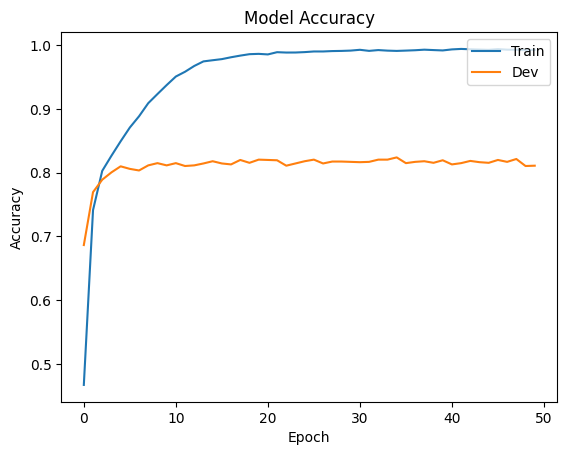

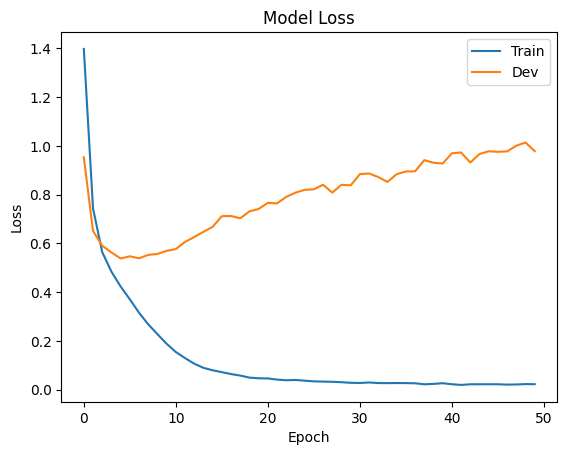

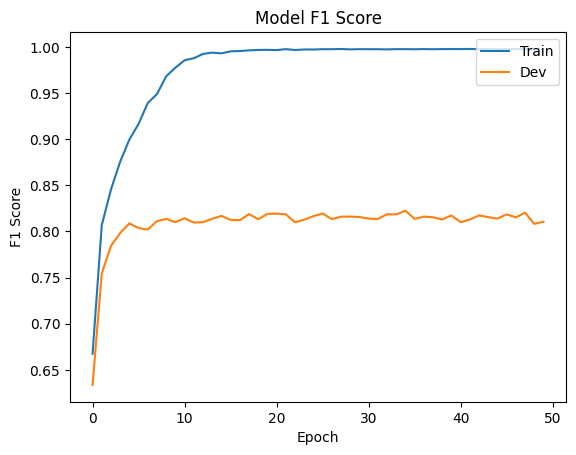

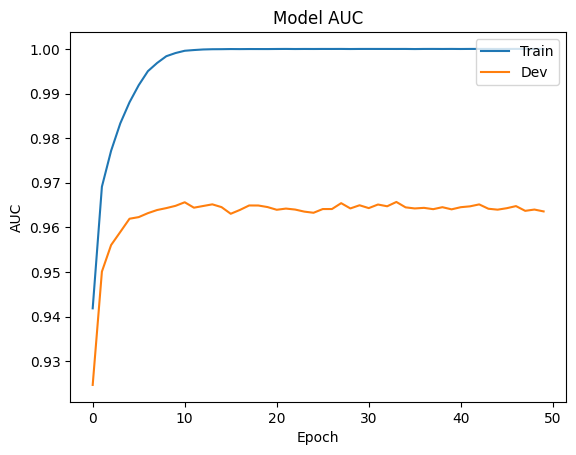

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for F1 score
plt.plot(history.history['train_f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for AUC
plt.plot(history.history['train_auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()


## **Evaluate performance of tf-idf non-tuned MLP model**

* Load the saved weights into the model
* Generate predictions on the validation set
* Convert numerical labels to their corresponding class names
* Print classification report for validation set
* Compute and Plot the confusion matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report for validation data:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       550
           1       0.87      0.87      0.87       704
           2       0.74      0.67      0.70       178
           3       0.84      0.81      0.82       275
           4       0.75      0.73      0.74       212
           5       0.70      0.62      0.66        81

    accuracy                           0.82      2000
   macro avg       0.79      0.76      0.78      2000
weighted avg       0.82      0.82      0.82      2000



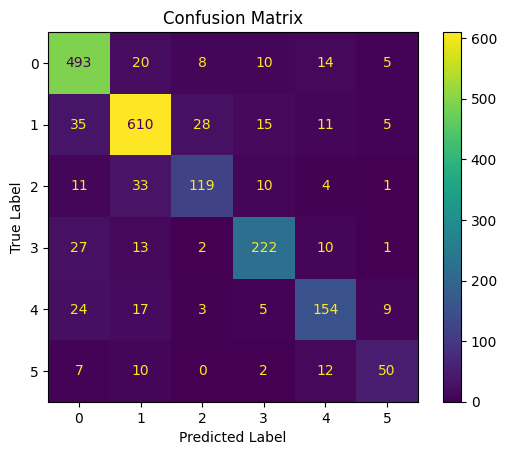

In [ ]:
distinct_train_labels_list=list(distinct_train_labels)
distinct_train_labels_string=[str(x) for x in distinct_train_labels_list]

# Load the saved weights into the model
model.load_weights('checkpoints/tfidf_mlp.weights.h5')


# Generate predictions on the validation set
predictions = np.argmax(model.predict(X_val_svd), -1)

# Convert numerical labels to their corresponding class names
predictions_classes = [distinct_train_labels_string[pred] for pred in predictions]
y_val_classes = [distinct_train_labels_string[label] for label in y_val]

# Print classification report for validation set
print("Classification Report for validation data:")
print(classification_report(y_val_classes, predictions_classes))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, predictions)

# Plotting the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=distinct_train_labels_string)
disp.plot(values_format=".0f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(label_mapping)

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


## **Tune the hyperparameters using the Keras_Tuner**

**Built a custom Function for hyperparameter tunning that searches:**
* The number of layers
* The number of neurons per layer
* The activation function per layer
* The Dropout percentage

In [ ]:
def build_model(hp):
    model = Sequential()

    layer_index = 0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=3)):
        if layer_index == 0:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=16,max_value=512,step=16),
                            activation=hp.Choice(name='activation_layer'+str(i),values=['relu','tanh']),
                            input_dim=X_train_svd.shape[1]
                           ))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6])))
        else:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=16,max_value=512,step=16),
                            activation=hp.Choice(name='activation_layer'+str(i),values=['relu','tanh'])))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6])))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(len(distinct_train_labels),  activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=[CategoricalAccuracy()])

    return model

#### Instantiate the Tuner

In [ ]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_categorical_accuracy',  # Tuning objective
    max_epochs=50,  # Maximum number of epochs to train
    factor=3,  # Reduction factor for number of models trained in each bracket
    directory='my_hyperparameter_tuning',  # Directory to store tuning results
    project_name='tfidf_mlp'  # Name of the tuning project
)
tuner.search_space_summary()

Reloading Tuner from my_hyperparameter_tuning/tfidf_mlp/tuner0.json
Search space summary
Default search space size: 11
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value':

#### Define the Tuning Objective

In [ ]:
# Start hyperparameter search
tuner.search(X_train_svd, y_train_1_hot,
             validation_data=(X_val_svd, y_val_1_hot),
             epochs=50, batch_size=128,
             callbacks=[early_stopping])

#### Run the Hyperparameter Search

In [ ]:
tuner.search_space_summary()  # Display search space summary
tuner.results_summary()  # Display tuning results summary

Search space summary
Default search space size: 11
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': N

#### Retrieve the Best Hyperparameters

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps}")

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b84ec119a50>
Best Hyperparameters:
{'num_layers': 2, 'units_0': 384, 'activation_0': 'relu', 'dropout_0': 0.30000000000000004, 'learning_rate': 0.001, 'units_1': 128, 'activation_1': 'tanh', 'dropout_1': 0.5, 'units_2': 128, 'activation_2': 'tanh', 'dropout_2': 0.4, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0046'}


#### Build and Train the Final Model

In [ ]:
# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Compile the model
final_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
                    metrics=[CategoricalAccuracy()])

# Train the model with the Metrics callback
history = final_model.fit(X_train_svd, y_train_1_hot,
                          validation_data=(X_val_svd, y_val_1_hot),
                          epochs=50,
                          callbacks=[Metrics(train_data=(X_train_svd, y_train_1_hot), valid_data=(X_val_svd, y_val_1_hot))])


Epoch 1/50


/home/gtriant/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/stepep - categorical_accuracy: 0.3336 - loss: 1.6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
 — train_f1: 0.532372 — train_precision: 0.552669 — train_recall: 0.617313 — train_auc: 0.905741
 — val_f1: 0.517233 — val_precision: 0.552492 — val_recall: 0.602500 — val_auc: 0.890008
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - categorical_accuracy: 0.3383 - loss: 1.6339 - val_categorical_accuracy: 0.6025 - val_loss: 1.2031 - val_f1: 0.5172 - val_recall: 0.6025 - val_precision: 0.5525 - val_auc: 0.8900 - train_f1: 0.5324 - train_recall: 0.6173 - train_precision: 0.5527 - train_auc: 0.9057
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - categorical_accuracy: 0.6241 - loss: 1.085
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
 — train_f1: 0.712041 — train_precision: 0.730791 — train_recall: 0.743437 — train_auc: 0.945589
 — val_f1: 0.672973 — val_precision: 0.691984 — val_recall: 0.711500 — val_auc: 0.932512
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categor

#### Evaluate the Final Model in the Dev Test

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for validation data:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       550
           1       0.83      0.85      0.84       704
           2       0.69      0.69      0.69       178
           3       0.78      0.77      0.78       275
           4       0.77      0.72      0.74       212
           5       0.71      0.64      0.68        81

    accuracy                           0.80      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.79      0.80      0.79      2000



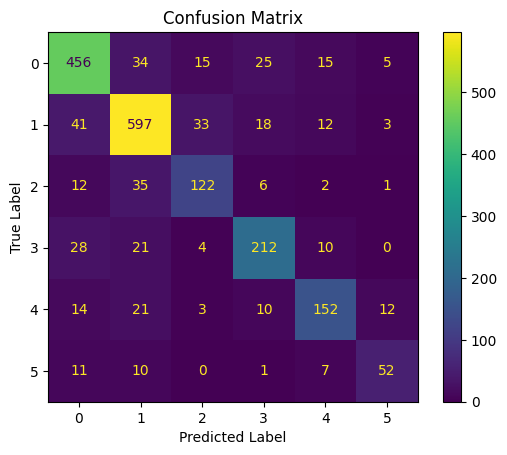

In [ ]:
predictions = np.argmax(final_model.predict(X_val_svd), axis=-1)
predictions_classes = [distinct_train_labels_string[pred] for pred in predictions]
y_val_classes = [distinct_train_labels_string[label] for label in y_val]

print("Classification Report for validation data:")
print(classification_report(y_val_classes, predictions_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=distinct_train_labels_string)
disp.plot(values_format=".0f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(label_mapping)

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


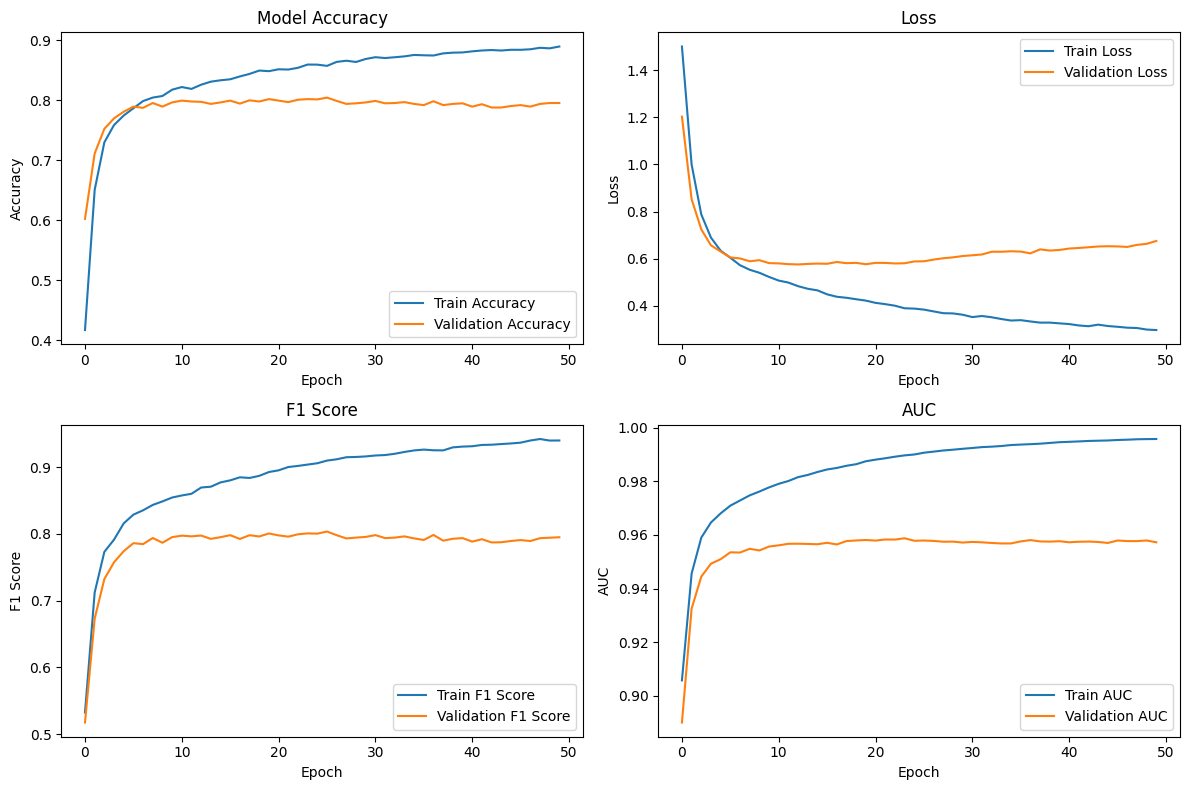

In [ ]:
# Extract metrics from tuning history
val_categorical_accuracy = history.history['val_categorical_accuracy']
val_loss = history.history['val_loss']
val_f1 = history.history['val_f1']
val_auc = history.history['val_auc']
train_categorical_accuracy = history.history['categorical_accuracy']
train_loss = history.history['loss']
train_f1 = history.history['train_f1']
train_auc = history.history['train_auc']

# Plot the metrics
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(train_categorical_accuracy, label='Train Accuracy')
plt.plot(val_categorical_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# F1 Score
plt.subplot(2, 2, 3)
plt.plot(train_f1, label='Train F1 Score')
plt.plot(val_f1, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# AUC
plt.subplot(2, 2, 4)
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Validation AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


### Evaluate the best Model In the test set

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
Classification Report for Test data:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       581
           1       0.82      0.84      0.83       695
           2       0.56      0.57      0.57       159
           3       0.77      0.78      0.78       275
           4       0.79      0.73      0.76       224
           5       0.68      0.68      0.68        66

    accuracy                           0.79      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.79      0.79      0.79      2000



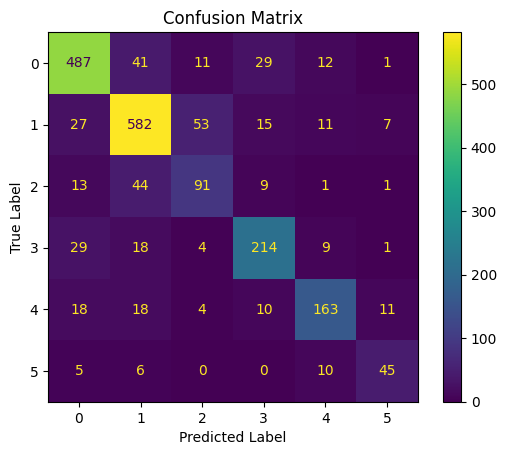

In [ ]:
predictions_test = np.argmax(final_model.predict(X_test_svd), axis=-1)
predictions_test_classes = [distinct_train_labels_string[pred] for pred in predictions_test]
y_test_classes = [distinct_train_labels_string[label] for label in y_test]

print("Classification Report for Test data:")
print(classification_report(y_test_classes, predictions_test_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=distinct_train_labels_string)
disp.plot(values_format=".0f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(label_mapping)

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
